# Import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image



from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models


from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.activations import swish

from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from itertools import product
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow import keras
import math
from tensorflow.keras.preprocessing import image

import csv

2025-05-17 19:49:59.471800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747511399.667538      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747511399.730800      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 7395 files belonging to 7 classes.
Using 5916 files for training.


I0000 00:00:1747511415.564300      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 7395 files belonging to 7 classes.
Using 1479 files for validation.
Class names: ['banana_overripe', 'banana_ripe', 'banana_rotten', 'banana_unripe', 'tomato_fully_ripened', 'tomato_green', 'tomato_half_ripened']

Class weights: {0: 0.6628571428571428, 1: 0.6702163815565877, 2: 0.4829387755102041, 3: 0.696163803247823, 4: 20.613240418118465, 5: 2.761904761904762, 6: 12.248447204968944}

=== CLASS VERIFICATION ===


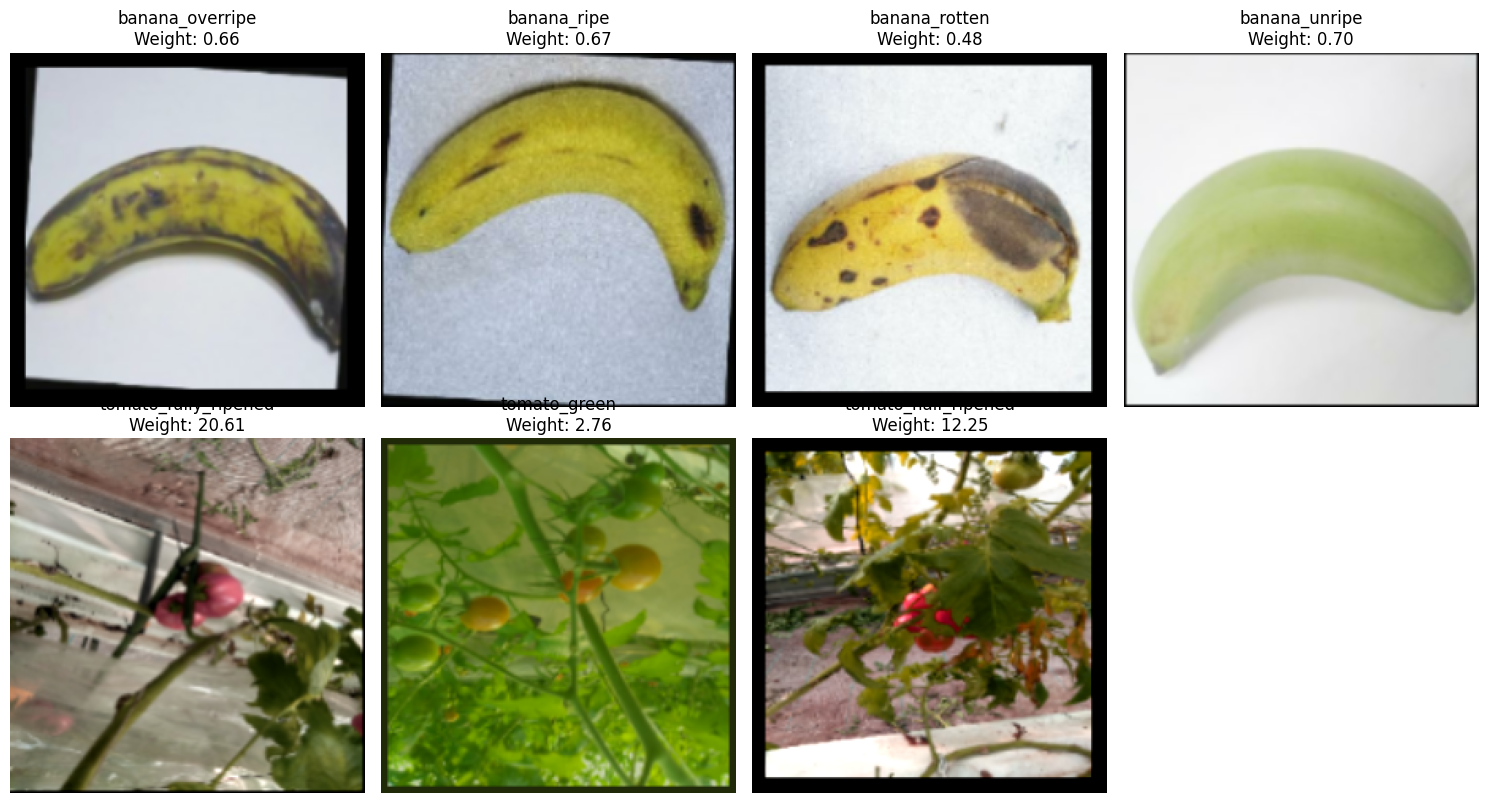

In [2]:
tf.random.set_seed(42)
np.random.seed(42)
img_size = 224
batch_size = 32
dataset_path = '/kaggle/input/fine-grained-fruit-quality-assessment/train/train'
dataset_test_path = '/kaggle/input/fine-grained-fruit-quality-assessment/test/testNew'
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical'
)

class_names = train_ds.class_names
print("Class names:", class_names)


labels = np.concatenate([y.numpy().argmax(1) for x, y in train_ds], axis=0)
class_weights = class_weight.compute_class_weight('balanced', 
                                               classes=np.unique(labels), 
                                               y=labels)
class_weights = dict(enumerate(class_weights))
print("\nClass weights:", class_weights)


def general_augmentations(image):
    image = tf.image.resize(image, (160, 160))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    crop_size = tf.random.uniform([], minval=140, maxval=160, dtype=tf.int32)
    image = tf.image.resize(image, [crop_size, crop_size])
    image = tf.image.resize_with_crop_or_pad(image, 160, 160)
    return image

def tomato_extra_augmentations(image):
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.image.random_hue(image, max_delta=0.08)
    return image


tomato_keywords = ['tomato_fully_ripened', 'tomato_green', 'tomato_half_ripened']
tomato_indices = [i for i, name in enumerate(class_names) if any(kw in name.lower() for kw in tomato_keywords)]
tomato_tensor = tf.constant(tomato_indices, dtype=tf.int64)

# process the imgs
def process_train(image, label):
    class_idx = tf.argmax(label)
    image = general_augmentations(image)
    is_tomato = tf.reduce_any(tf.equal(class_idx, tomato_tensor))
    image = tf.cond(
        is_tomato,
        lambda: tomato_extra_augmentations(image),
        lambda: image
    )
    image = tf.image.resize(image, (img_size, img_size))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def process_val(image, label):
    image = tf.image.resize(image, (img_size, img_size))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Dataset pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = (train_ds.unbatch()
           .map(process_train, num_parallel_calls=AUTOTUNE)
           .batch(batch_size))
val_ds = (val_ds.unbatch()
         .map(process_val, num_parallel_calls=AUTOTUNE)
         .batch(batch_size))

train_ds_t=train_ds.repeat()
train_ds_t=train_ds_t.cache().prefetch(AUTOTUNE)
val_ds_t=val_ds.repeat()
val_ds_t= val_ds_t.cache().prefetch(AUTOTUNE)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

# Verification
print("\n=== CLASS VERIFICATION ===")

class_examples = {class_name: {'image': None, 'weight': None} for class_name in class_names}

for images, labels in train_ds:
    class_indices = tf.argmax(labels, axis=1).numpy()
    for i in range(len(class_indices)):
        class_name = class_names[class_indices[i]]
        if class_examples[class_name]['image'] is None:
            class_examples[class_name]['image'] = images[i]
            class_examples[class_name]['weight'] = class_weights[class_indices[i]]
    
    if all(v['image'] is not None for v in class_examples.values()):
        break

plt.figure(figsize=(15, 8))
for idx, (class_name, example) in enumerate(class_examples.items()):
    plt.subplot(2, 4, idx+1)  # Adjust grid based on number of classes
    plt.imshow(example['image'])
    plt.title(f"{class_name}\nWeight: {example['weight']:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# EffcientNetV2B0

## Architecture

In [3]:
#Squeeze
def se_block(x, ratio=8):
    filters = x.shape[-1]
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, filters))(se)
    return layers.multiply([x, se])


def depthwise_separable_conv_block(x, filters, kernel_size, strides=1, padding='same'):
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish)(x)
    x = layers.Conv2D(filters, (1, 1), padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish)(x)
    x = se_block(x)
    return x

def compound_scaling(input_tensor, filters, kernel_size=(3, 3), scale_factor=1.0):
    filters = int(filters * scale_factor)
    return depthwise_separable_conv_block(input_tensor, filters, kernel_size)

def build_efficientnet_like_model(input_shape=(224, 224, 3), num_classes=7, scale_factor=1.0):  
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding='same', strides=2)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish)(x)

    x = compound_scaling(x, filters=32, scale_factor=scale_factor)
    x = compound_scaling(x, filters=64, scale_factor=scale_factor)
    x = compound_scaling(x, filters=128, scale_factor=scale_factor)
    x = compound_scaling(x, filters=256, scale_factor=scale_factor)
    x = compound_scaling(x, filters=512, scale_factor=scale_factor)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation=swish)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=x)
    return model

model = build_efficientnet_like_model(input_shape=(224, 224, 3), num_classes=7, scale_factor=1.2)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  
)



train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True
    )
]

Found 5917 images belonging to 7 classes.
Found 1478 images belonging to 7 classes.


In [4]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 112, 112, 32)   │            320 │ activation[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 32)   │            128 │ depthwise_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 112, 112, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 112, 112, 38)   │          1,254 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 38)   │            152 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 112, 112, 38)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 38)             │              0 │ activation_2[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 4)              │            156 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 38)             │            190 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 38)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 112, 112, 38)   │              0 │ activation_2[0][0],    │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d_1        │ (None, 112, 112, 38)   │            380 │ multiply[0][0]         │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 1,029,064 (3.93 MB)

 Trainable params: 1,025,412 (3.91 MB)

 Non-trainable params: 3,652 (14.27 KB)

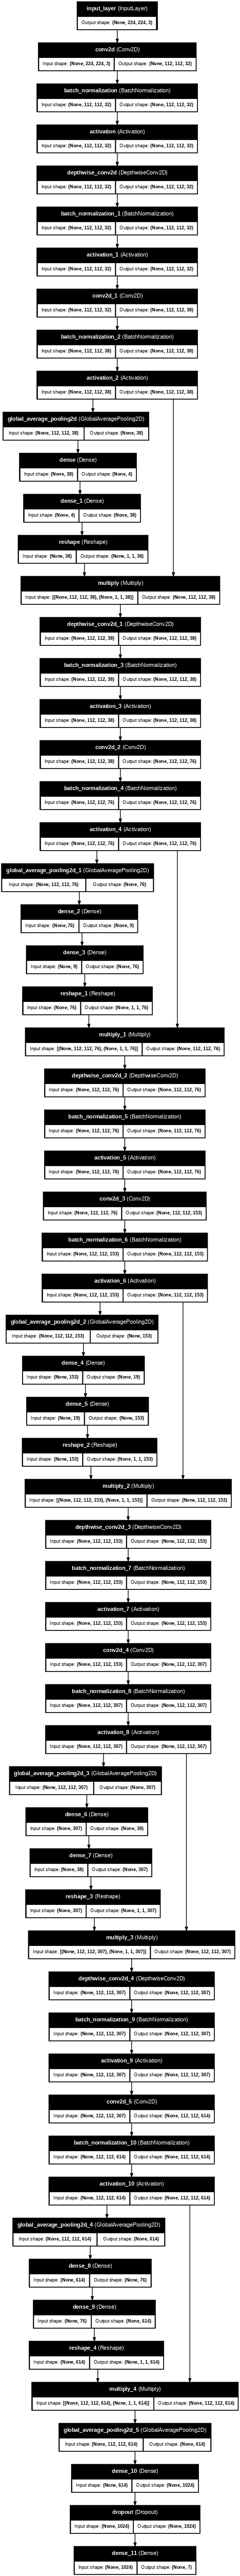

In [5]:
plot_model(
    model,
    to_file='/kaggle/working/efficientnet_like_model.png',
    show_shapes=True,
    show_layer_names=True,
    dpi=48  
)

## Trian

In [6]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,
    callbacks=callbacks
)

train_loss, train_acc = model.evaluate(train_generator)
print(f"Training Accuracy: {train_acc}")

model.save('/kaggle/working/efficientnet_model.h5') 
print("Model saved to '/kaggle/working/efficientnet_model.h5'")

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747511464.237536      63 service.cc:148] XLA service 0x7c5ec8002320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747511464.238341      63 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747511465.651817      63 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1747511468.520446      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747511468.774496      63 gpu_timer.cc:

147/185 ━━━━━━━━━━━━━━━━━━━━ 21s 570ms/step - accuracy: 0.6282 - loss: 1.1743

E0000 00:00:1747511577.016018      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747511577.269347      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747511580.675108      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747511580.927117      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747511586.429379      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.6585 - loss: 1.1219

E0000 00:00:1747511642.704795      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747511642.948365      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


185/185 ━━━━━━━━━━━━━━━━━━━━ 212s 905ms/step - accuracy: 0.6592 - loss: 1.1207 - val_accuracy: 0.2097 - val_loss: 1.8668 - learning_rate: 0.0010
Epoch 2/40
185/185 ━━━━━━━━━━━━━━━━━━━━ 123s 642ms/step - accuracy: 0.8779 - loss: 0.7193 - val_accuracy: 0.2097 - val_loss: 2.0083 - learning_rate: 0.0010
Epoch 3/40
185/185 ━━━━━━━━━━━━━━━━━━━━ 123s 639ms/step - accuracy: 0.9031 - loss: 0.6617 - val_accuracy: 0.4533 - val_loss: 1.5554 - learning_rate: 0.0010
Epoch 4/40
185/185 ━━━━━━━━━━━━━━━━━━━━ 121s 631ms/step - accuracy: 0.9136 - loss: 0.6383 - val_accuracy: 0.7355 - val_loss: 1.0339 - learning_rate: 0.0010
Epoch 5/40
185/185 ━━━━━━━━━━━━━━━━━━━━ 122s 640ms/step - accuracy: 0.9255 - loss: 0.6086 - val_accuracy: 0.7591 - val_loss: 0.9392 - learning_rate: 0.0010
Epoch 6/40
185/185 ━━━━━━━━━━━━━━━━━━━━ 123s 645ms/step - accuracy: 0.9239 - loss: 0.6138 - val_accuracy: 0.8647 - val_loss: 0.7223 - learning_rate: 0.0010
Epoch 7/40
185/185 ━━━━━━━━━━━━━━━━━━━━ 121s 635ms/step - accuracy: 0.9346 

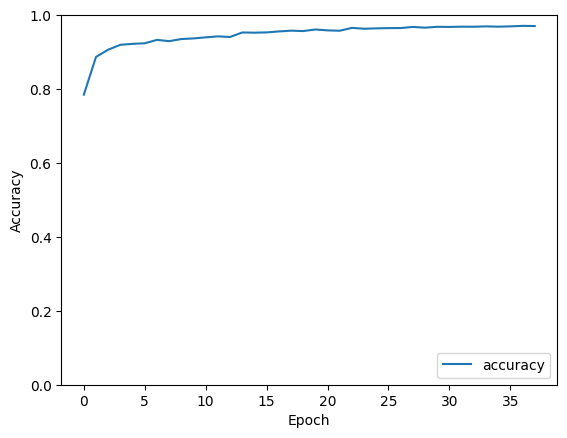

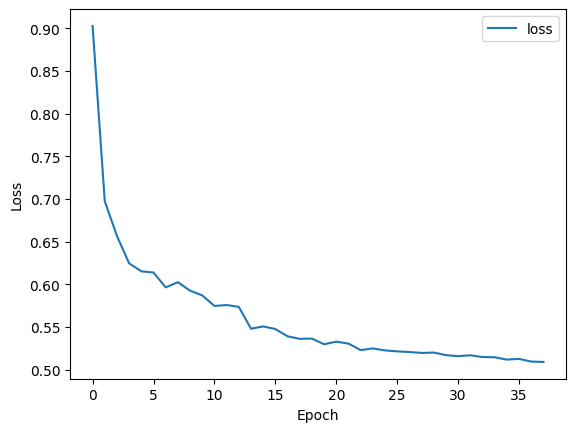

In [7]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

## Prediction

In [8]:
label_map = {
    0: "banana_overripe",
    1: "banana_ripe",
    2: "banana_rotten",
    3: "banana_unripe",
    4: "tomato_fully_ripened",
    5: "tomato_green",
    6: "tomato_half_ripened"
}

images = []
image_names = []

for img_name in os.listdir(dataset_test_path):
    img_path = os.path.join(dataset_test_path, img_name)
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    images.append(img_array)
    image_names.append(img_name)

images_np = np.array(images)
preds = model.predict(images_np, verbose=0)
class_indices = np.argmax(preds, axis=1)

# Save results with numeric class index instead of label
results = [{"ImageID": name, "Class": idx} for name, idx in zip(image_names, class_indices)]


df = pd.DataFrame(results)
df.to_csv("/kaggle/working/effcientnetpredictions.csv", index=False)

print("Predictions saved to effcientnetpredictions.csv")

E0000 00:00:1747516304.730521      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747516304.979561      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


Predictions saved to effcientnetpredictions.csv


# Transformer

## Architecure

In [9]:
import tensorflow as tf
from tensorflow.keras import layers

@tf.keras.utils.register_keras_serializable()
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
        })
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        return tf.reshape(patches, [batch_size, -1, patch_dims])


@tf.keras.utils.register_keras_serializable()
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches    = num_patches
        self.projection     = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches":    self.num_patches,
            "projection_dim": self.projection.units,
        })
        return config

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded


In [10]:
class TransformerBlock(layers.Layer):
    def __init__(self, projection_dim, num_heads, transformer_units, dropout_rate=0.1):
        super().__init__()
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)
        self.drop1 = layers.Dropout(dropout_rate)
        self.add1 = layers.Add()
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dense1 = layers.Dense(transformer_units[0], activation=tf.nn.gelu)
        self.drop2 = layers.Dropout(dropout_rate)
        self.dense2 = layers.Dense(transformer_units[1], activation=tf.nn.gelu)
        self.drop3 = layers.Dropout(dropout_rate)
        self.dense3 = layers.Dense(projection_dim)
        self.add2 = layers.Add()
    def call(self, inputs, training=False):
        x1 = self.norm1(inputs)
        attn = self.att(x1, x1, training=training)
        attn = self.drop1(attn, training=training)
        x2 = self.add1([attn, inputs])
        x3 = self.norm2(x2)
        x3 = self.dense1(x3)
        x3 = self.drop2(x3, training=training)
        x3 = self.dense2(x3)
        x3 = self.drop3(x3, training=training)
        x3 = self.dense3(x3)
        return self.add2([x3, x2])

def create_vit_classifier(
    input_shape=(224, 224, 3),
    patch_size=8,
    projection_dim=64,
    transformer_layers=4,
    num_heads=4,
    transformer_units=[128, 64],
    mlp_head_units=[128],
    num_classes=7,
    dropout_rate=0.2
):
    num_patches = (input_shape[0] // patch_size) ** 2
    inputs = layers.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    for _ in range(transformer_layers):
        encoded_patches = TransformerBlock(
            projection_dim=projection_dim,
            num_heads=num_heads,
            transformer_units=transformer_units,
            dropout_rate=dropout_rate
        )(encoded_patches)
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    for units in mlp_head_units:
        representation = layers.Dense(units, activation=tf.nn.gelu)(representation)
        representation = layers.Dropout(dropout_rate)(representation)
    logits = layers.Dense(num_classes, activation='softmax')(representation)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## Train

In [11]:
params = {
    'patch_size': 16,              
    'projection_dim': 128,         
    'transformer_layers': 6,       
    'num_heads': 8,              
    'mlp_head_units': [256, 128],
    'learning_rate': 1e-4,        
    'dropout_rate': 0.1            
}

model = create_vit_classifier(
    input_shape=(img_size, img_size, 3),
    patch_size=params['patch_size'],
    projection_dim=params['projection_dim'],
    transformer_layers=params['transformer_layers'],
    num_heads=params['num_heads'],
    transformer_units=[128, 64],
    mlp_head_units=params['mlp_head_units'],
    num_classes=len(class_names),
    dropout_rate=params['dropout_rate']
)

class WarmUpCosine(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, total_steps, warmup_steps, min_lr=1e-6):
        super().__init__()
        self.base_lr = base_lr
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.min_lr = min_lr
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_lr = self.base_lr * (step / tf.cast(self.warmup_steps, tf.float32))
        cosine_lr = self.min_lr + 0.5 * (self.base_lr - self.min_lr) * (1 + tf.cos(
            np.pi * (step - self.warmup_steps) / float(self.total_steps - self.warmup_steps)
        ))
        return tf.cond(step < self.warmup_steps, lambda: warmup_lr, lambda: cosine_lr)
    def get_config(self):
        return {
            "base_lr": self.base_lr,
            "total_steps": self.total_steps,
            "warmup_steps": self.warmup_steps,
            "min_lr": self.min_lr,
        }

In [12]:
num_train_samples = 0
for _ in train_ds.unbatch():
    num_train_samples += 1

steps_per_epoch = int(np.ceil(num_train_samples / batch_size))
total_steps = steps_per_epoch * 30
warmup_steps = steps_per_epoch * 3
lr_schedule = WarmUpCosine(params['learning_rate'], total_steps, warmup_steps)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    verbose=1,
    class_weight=class_weights,
    callbacks=callbacks
)

model.save('vit_model.h5')
print("Model saved as 'vit_model.h5'")

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

Epoch 1/30
    185/Unknown 83s 183ms/step - accuracy: 0.2164 - loss: 2.0708

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


185/185 ━━━━━━━━━━━━━━━━━━━━ 94s 239ms/step - accuracy: 0.2166 - loss: 2.0697 - val_accuracy: 0.4855 - val_loss: 1.2517
Epoch 2/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.3898 - loss: 1.5488 - val_accuracy: 0.6383 - val_loss: 0.9263
Epoch 3/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.5193 - loss: 1.3344 - val_accuracy: 0.7262 - val_loss: 0.7696
Epoch 4/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.5816 - loss: 1.2850 - val_accuracy: 0.7208 - val_loss: 0.8508
Epoch 5/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.6903 - loss: 0.8859 - val_accuracy: 0.7546 - val_loss: 0.8056
Epoch 6/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.7512 - loss: 0.6708 - val_accuracy: 0.7417 - val_loss: 0.8274
Epoch 7/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.7725 - loss: 0.6142 - val_accuracy: 0.8005 - val_loss: 0.6578
Epoch 8/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.7984 - loss: 0.5044 - val_accura

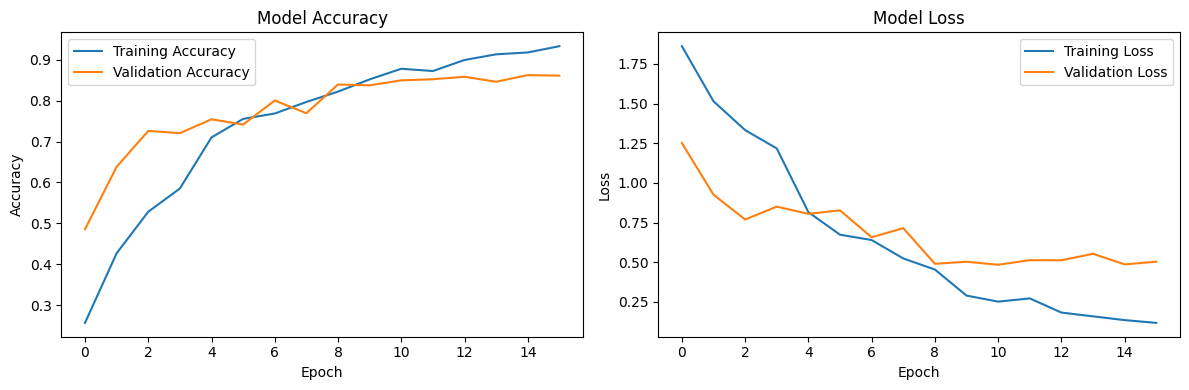

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## Test

In [15]:
test_image_names = os.listdir(dataset_test_path)
test_images = []
valid_test_names = []

print(f"Processing {len(test_image_names)} test images...")

for fname in test_image_names:
    if fname.lower().endswith('.jpg'):
        img_path = os.path.join(dataset_test_path, fname)
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [img_size, img_size])
        img = tf.cast(img, tf.float32) / 255.0
        test_images.append(img)
        valid_test_names.append(fname)


if test_images:
    test_images = tf.stack(test_images)
    preds = model.predict(test_images, verbose=1)
    class_indices = np.argmax(preds, axis=1)
    
    results = [{"ImageID": name, "Class": idx} for name, idx in zip(valid_test_names, class_indices)]
    
    df = pd.DataFrame(results)
    df.to_csv("/kaggle/working/vit_predictions.csv", index=False)
    print(f"\nPredictions saved to vit_predictions.csv")
    print(f"Processed {len(valid_test_names)} images successfully")
    print("\nSample predictions:")
    print(df.head())
else:
    print('No valid test images found in the test directory.')

Processing 2484 test images...
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step

Predictions saved to vit_predictions.csv
Processed 2484 images successfully

Sample predictions:
              ImageID  Class
0  testimage_1318.jpg      2
1  testimage_2053.jpg      3
2  testimage_1958.jpg      2
3   testimage_934.jpg      2
4  testimage_1677.jpg      1


# GoogleNet

## Inception Module

In [16]:
def inception_module(x, f1, f3r, f3, f5r, f5, proj, name):
    path1 = layers.Conv2D(f1, 1, padding='same', activation='relu')(x)

    path2 = layers.Conv2D(f3r, 1, activation='relu', padding='same')(x)
    path2 = layers.Conv2D(f3, 3, activation='relu', padding='same')(path2)

    path3 = layers.Conv2D(f5r, 1, activation='relu', padding='same')(x)
    path3 = layers.Conv2D(f5, 5, activation='relu', padding='same')(path3)

    path4 = layers.MaxPooling2D(3, strides=1, padding='same')(x)
    path4 = layers.Conv2D(proj, 1, activation='relu', padding='same')(path4)

    return layers.Concatenate(name=name)([path1, path2, path3, path4])

## Architecture

In [17]:
def build_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(64, 1, activation='relu')(x)
    x = layers.Conv2D(192, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = inception_module(x, 64, 96, 128, 16, 32, 32, name='inception_3a')
    x = inception_module(x, 128, 128, 192, 32, 96, 64, name='inception_3b')
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64, name='inception_4a')
    x = inception_module(x, 160, 112, 224, 24, 64, 64, name='inception_4b')
    x = inception_module(x, 128, 128, 256, 24, 64, 64, name='inception_4c')
    x = inception_module(x, 112, 144, 288, 32, 64, 64, name='inception_4d')
    x = inception_module(x, 256, 160, 320, 32, 128, 128, name='inception_4e')
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = inception_module(x, 256, 160, 320, 32, 128, 128, name='inception_5a')
    x = inception_module(x, 384, 192, 384, 48, 128, 128, name='inception_5b')

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(7, activation='softmax', dtype='float32')(x)

    return models.Model(inputs, outputs)

model = build_model()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 112, 112, 64)   │          9,472 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 56, 56, 64)     │            256 │ max_pooling2d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 56, 56, 64)     │          4,160 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 56, 56, 192)    │        110,784 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 28, 28, 192)    │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 28, 28, 96)     │         18,528 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 28, 28, 16)     │          3,088 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 192)    │              0 │ max_pooling2d_1[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 28, 28, 64)     │         12,352 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 28, 28, 128)    │        110,720 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 28, 28, 32)     │         12,832 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 28, 28, 32)     │          6,176 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_3a              │ (None, 28, 28, 256)    │              0 │ conv2d_9[0][0],        │
│ (Concatenate)             │                        │                │ conv2d_11[0][0],       │
│                           │                        │                │ conv2d_13[0][0],       │
│                           │                        │                │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)   

 Total params: 6,239,031 (23.80 MB)

 Trainable params: 6,238,391 (23.80 MB)

 Non-trainable params: 640 (2.50 KB)

## Train

In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.3, min_lr=1e-6, verbose=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    class_weight=class_weights,
    callbacks=callbacks
)

model.save("googlenet.keras")

Epoch 1/100
    185/Unknown 75s 174ms/step - accuracy: 0.1788 - loss: 2.0068

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


185/185 ━━━━━━━━━━━━━━━━━━━━ 86s 230ms/step - accuracy: 0.1790 - loss: 2.0060 - val_accuracy: 0.2968 - val_loss: 1.8876 - learning_rate: 3.0000e-04
Epoch 2/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.4078 - loss: 1.4861 - val_accuracy: 0.4334 - val_loss: 1.6850 - learning_rate: 3.0000e-04
Epoch 3/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.6274 - loss: 1.2863 - val_accuracy: 0.5876 - val_loss: 1.4254 - learning_rate: 3.0000e-04
Epoch 4/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.7592 - loss: 1.1499 - val_accuracy: 0.8012 - val_loss: 0.9045 - learning_rate: 3.0000e-04
Epoch 5/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.8444 - loss: 1.0209 - val_accuracy: 0.8357 - val_loss: 0.8315 - learning_rate: 3.0000e-04
Epoch 6/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.8699 - loss: 0.9947 - val_accuracy: 0.8174 - val_loss: 0.8433 - learning_rate: 3.0000e-04
Epoch 7/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - 

## Plot

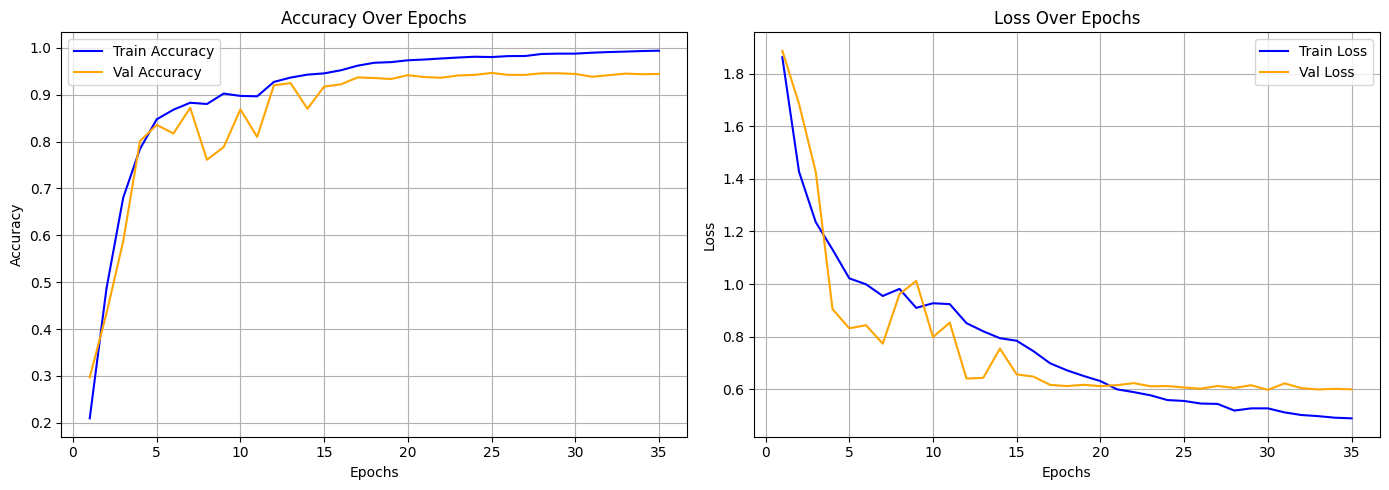

In [19]:
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Train Loss')
    plt.plot(epochs, val_loss, 'orange', label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training(history)

In [20]:
img_size = 224
test_folder = '/kaggle/input/fine-grained-fruit-quality-assessment/test/testNew'  
model_path = '/kaggle/working/final_model2.keras'
output_csv = '/kaggle/working/googlenet_predictions.csv'
expected_classes = {
    0: 'banana_overripe',
    1: 'banana_ripe',
    2: 'banana_rotten',
    3: 'banana_unripe',
    4: 'tomato_fully_ripened',
    5: 'tomato_green',
    6: 'tomato_half_ripened'
}
print("Loading model...")
try:
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully.")
except ValueError as e:
    print(f"Error loading model: {e}")

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img).astype('float32')
    img_array = img_array / 255.0 
    return np.expand_dims(img_array, axis=0)

results = []

print(f"Predicting for images in: {test_folder}")
for fname in sorted(os.listdir(test_folder)):
    if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
        continue

    img_path = os.path.join(test_folder, fname)
    img_tensor = preprocess_image(img_path)
    preds = model.predict(img_tensor, verbose=0)
    pred_class = int(np.argmax(preds[0]))

    results.append((fname, pred_class))

with open(output_csv, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['ImageID', 'Class'])
    writer.writerows(results)

print(f"\n Predictions saved to '{output_csv}'")

Loading model...
Error loading model: File not found: filepath=/kaggle/working/final_model2.keras. Please ensure the file is an accessible `.keras` zip file.
Predicting for images in: /kaggle/input/fine-grained-fruit-quality-assessment/test/testNew

 Predictions saved to '/kaggle/working/googlenet_predictions.csv'
